# Doordash Delivery Time Prediction

This project aims to predict the total delivery time for Doordash orders using multiple algorithms. Key steps include data preprocessing, feature engineering, handling multicollinearity, and scaling the data. 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r'D:\UNIVERSITY\DataScience\datasets\historical_data.csv'
data = pd.read_csv(file_path)

data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [2]:
max_duration_row = data.loc[data['estimated_order_place_duration'].idxmax()] 
max_duration_row

market_id                                                       1.0
created_at                                      2015-02-08 20:15:10
actual_delivery_time                            2015-02-08 21:48:14
store_id                                                       5761
store_primary_category                                     sandwich
order_protocol                                                  5.0
total_items                                                       2
subtotal                                                       2630
num_distinct_items                                                2
min_item_price                                                 1260
max_item_price                                                 1370
total_onshift_dashers                                          16.0
total_busy_dashers                                             16.0
total_outstanding_orders                                       31.0
estimated_order_place_duration                  

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

# Converting columns to datetime and making new columns and then one hot encoding, droping and fillanlly concating the resulting dataframe

In [4]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

In [5]:
from datetime import datetime
data['Totaltime'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [6]:
data['busyRatio'] = data['total_busy_dashers'] / data['total_onshift_dashers']

In [7]:
data['estimated_non_prep_duration'] = data['estimated_store_to_consumer_driving_duration'] + data['estimated_order_place_duration']

In [8]:
data['market_id'].nunique()

6

In [9]:
data['store_id'].nunique()

6743

In [10]:
data['order_protocol'].nunique()

7

In [11]:
mark = pd.get_dummies(data['market_id']).add_prefix('market_id_')

mark.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,False,True,False,False,False


In [12]:
order = pd.get_dummies(data['order_protocol']).add_prefix('order_protocol_')
order.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,True,False,False,False,False,False,False
1,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [13]:
storeUnique = data['store_id'].unique().tolist()

storeidandCategory = {
    store_id: data[data['store_id'] == store_id]['store_primary_category'].mode()
    for store_id in storeUnique
}


In [14]:
def fill(store_id):
    try:
        """Return primary store category from the dictionary"""
        return storeidandCategory[store_id].values[0]
    except:
        return np.nan
# fill null values
data["nan_free_store_primary_category"] = data['store_id'].apply(fill)

In [15]:
store_p_cat_dum = pd.get_dummies(data['nan_free_store_primary_category']).add_prefix('category_')


In [16]:
train_df = data.drop(columns =
                    ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time"
, "nan_free_store_primary_category",'order_protocol'])

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,Totaltime,busyRatio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [17]:
train_df = pd.concat([train_df,order,mark,store_p_cat_dum ],axis=1)
train_df = train_df.astype('float32')
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
np.where(np.any(~np.isfinite(train_df),axis=0) == True)
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
train_df.dropna(inplace=True)

In [19]:
train_df.shape

(177070, 100)

# Making a correlation heatmap just for lower triangle to peed up computing

In [20]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

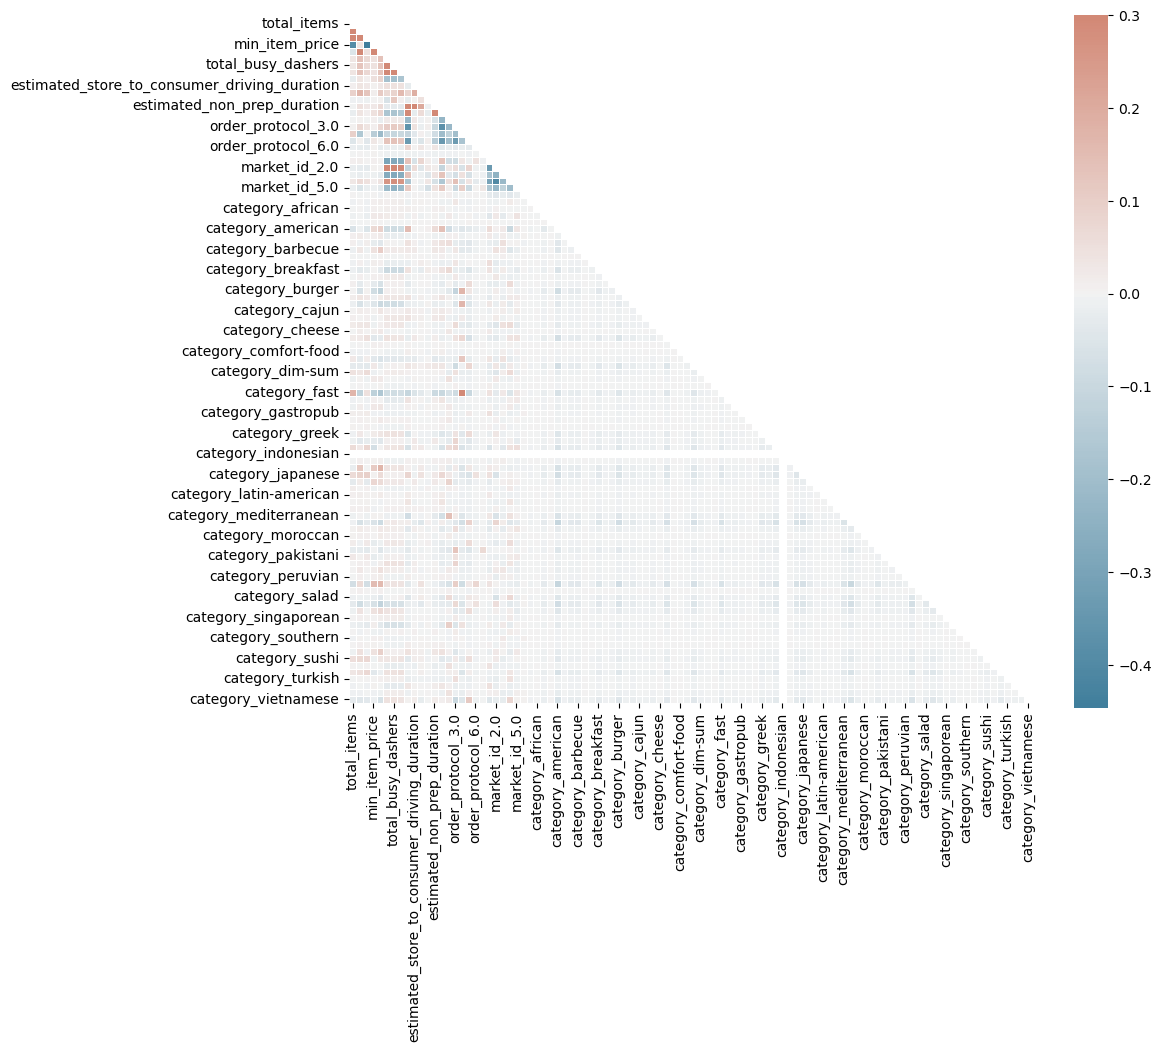

In [21]:
f, ax = plt.subplots(figsize= (11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0, square = True, linewidth =.5)
plt.show()

# Dropping redundant pairs, getting most correlated values and dropping them and repeat

In [22]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [23]:
def get_top_abs_correlations(df,n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending =False)
    return au_corr[0:n]

In [24]:
print(get_top_abs_correlations(train_df,20))

total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items                            min_item

In [25]:
train_df = data.drop(columns=["created_at", "market_id", "store_id", "store_primary_category", 
                                         "actual_delivery_time", "nan_free_store_primary_category", "order_protocol"])

In [26]:
train_df = pd.concat([train_df,order,store_p_cat_dum ],axis=1)
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers", 
                                  "category_indonesian", "estimated_non_prep_duration"])


In [27]:
train_df = train_df.astype('float32')
#np.where(np.any(~np.isfinite(train_df),axis=0) == True)
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
train_df.dropna(inplace=True)

In [28]:
train_df.shape

(177070, 90)

In [29]:
print(get_top_abs_correlations(train_df,20))

estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duration  order_protocol_2.0    0

In [30]:
train_df = data.drop(columns=["created_at", "market_id", "store_id", "store_primary_category", 
                                         "actual_delivery_time", "nan_free_store_primary_category", "order_protocol"])
train_df = pd.concat([train_df,store_p_cat_dum ],axis=1)
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers", 
                                  "category_indonesian", "estimated_non_prep_duration"])
train_df = train_df.astype('float32')
#np.where(np.any(~np.isfinite(train_df),axis=0) == True)
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
train_df.dropna(inplace=True)
print(get_top_abs_correlations(train_df,20))

total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  Totaltime                         0.188418
subtotal                                      Totaltime                         0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
max_item_price       

In [31]:
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  Totaltime                         0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

In [32]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  Totaltime                         0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      Totaltime                         0.15

In [33]:
train_df.shape

(177070, 82)

# Computing vif and removing high vif values

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(features) :
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

features = train_df.drop(columns=["Totaltime"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000370
1,category_chocolate,1.000489
2,category_belgian,1.000749
3,category_russian,1.003226
4,category_african,1.003820
...,...,...
76,busyRatio,6.369592
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210800
79,estimated_order_place_duration,13.472056


In [51]:
multicollinearity = True
while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data['VIF'] > 5]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data


I will remove estimated_store_to_consumer_driving_duration
I will remove busyRatio
I will remove avg_price_per_item


,feature,VIF
0,category_chocolate,1.000004
1,category_alcohol-plus-food,1.000006
2,category_belgian,1.000017
3,category_comfort-food,1.000108
4,category_gluten-free,1.000176
...,...,...
71,category_mexican,1.259169
72,category_pizza,1.261277
73,price_range_of_items,2.241038
74,total_outstanding_orders,2.426982


In [38]:
selected_features

['category_alcohol-plus-food',
 'category_belgian',
 'category_chocolate',
 'category_gluten-free',
 'category_russian',
 'category_african',
 'category_comfort-food',
 'category_european',
 'category_spanish',
 'category_moroccan',
 'category_cheese',
 'category_southern',
 'category_singaporean',
 'category_soup',
 'category_kosher',
 'category_irish',
 'category_german',
 'category_argentine',
 'category_tapas',
 'category_lebanese',
 'category_malaysian',
 'category_afghan',
 'category_pakistani',
 'category_ethiopian',
 'category_british',
 'category_gastropub',
 'category_turkish',
 'category_convenience-store',
 'category_vegan',
 'category_filipino',
 'category_peruvian',
 'category_caribbean',
 'category_nepalese',
 'category_brazilian',
 'category_bubble-tea',
 'category_cajun',
 'category_latin-american',
 'category_french',
 'category_burmese',
 'category_pasta',
 'category_vegetarian',
 'category_persian',
 'category_dim-sum',
 'category_smoothie',
 'category_hawaiian',
 '

# Splitting data and calculating ginis importance

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = train_df[selected_features]
y = train_df["Totaltime"]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (141656, 76)
y_train shape: (141656,)


In [53]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

feats = {}  
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance  

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})


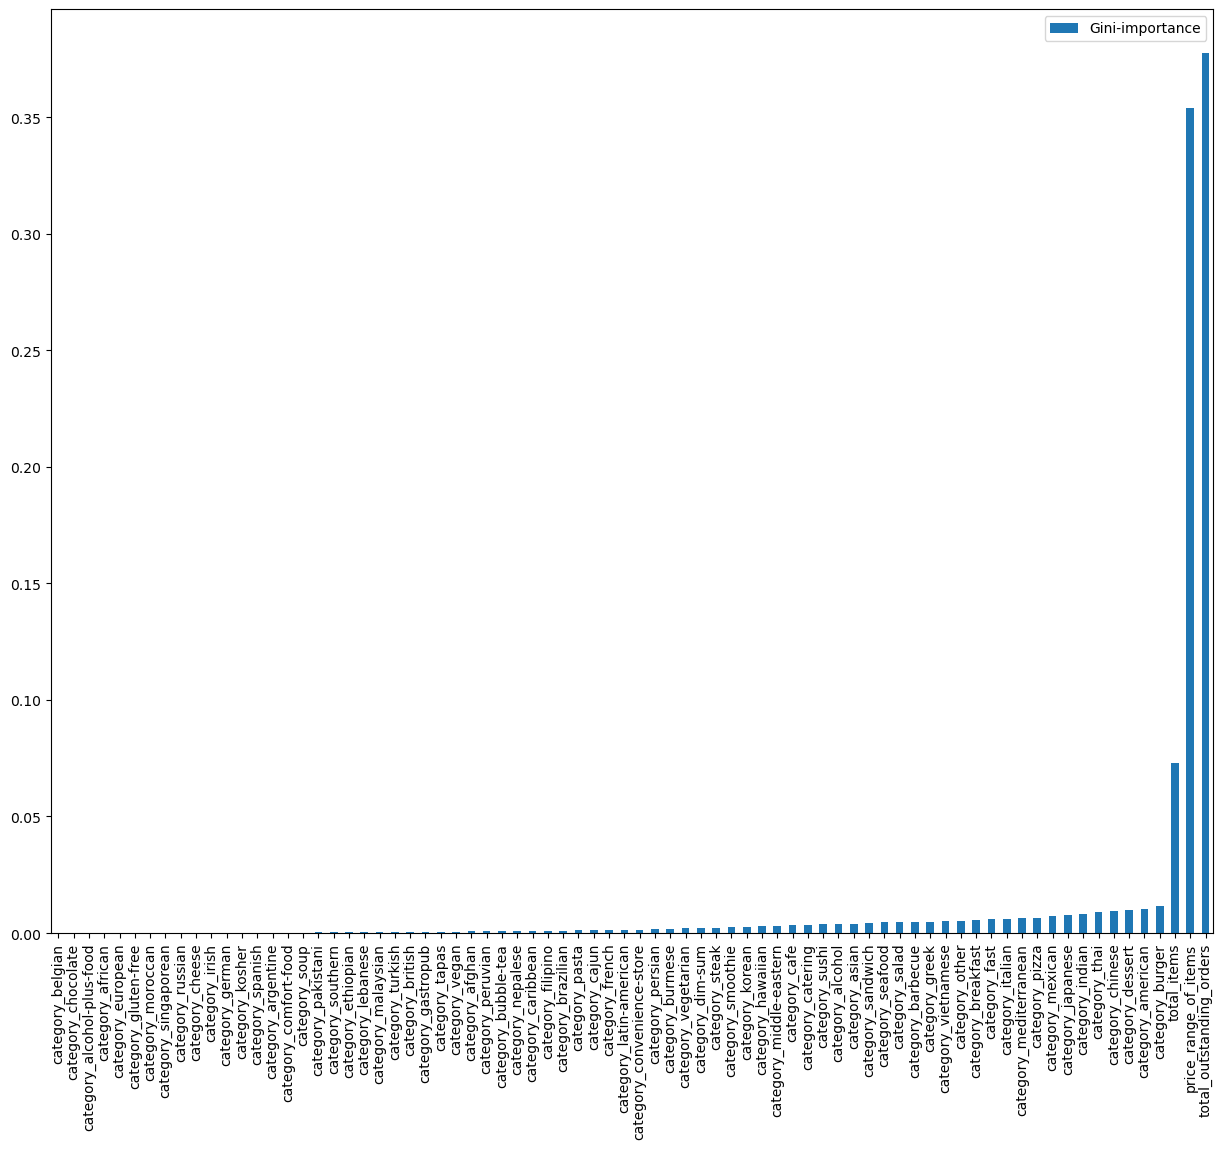

In [54]:
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15, 12))
plt.show()

In [55]:
importances.sort_values(by='Gini-importance').index.tolist()[-35:]


['category_vegetarian',
 'category_dim-sum',
 'category_steak',
 'category_smoothie',
 'category_korean',
 'category_hawaiian',
 'category_middle-eastern',
 'category_cafe',
 'category_catering',
 'category_sushi',
 'category_alcohol',
 'category_asian',
 'category_sandwich',
 'category_seafood',
 'category_salad',
 'category_barbecue',
 'category_greek',
 'category_vietnamese',
 'category_other',
 'category_breakfast',
 'category_fast',
 'category_italian',
 'category_mediterranean',
 'category_pizza',
 'category_mexican',
 'category_japanese',
 'category_indian',
 'category_thai',
 'category_chinese',
 'category_dessert',
 'category_american',
 'category_burger',
 'total_items',
 'price_range_of_items',
 'total_outstanding_orders']

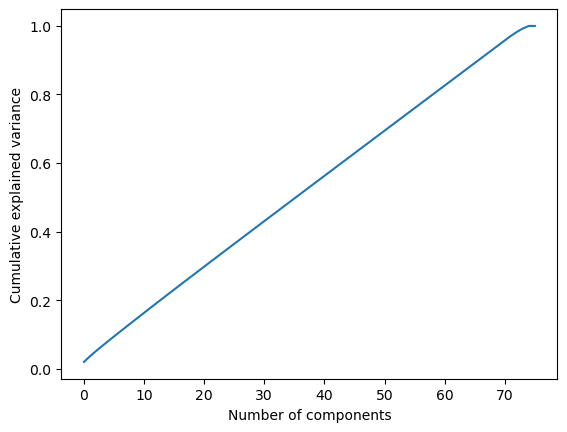

In [56]:
 from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

X_Train = X_train.values
X_Train = np.asarray(X_Train)
X_std = StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


# Making a function to scale, calculate rmse and reggession algoritms to avoid repition and finally training

In [57]:
def scale(scaler, X, y):
    X_scaler = scaler
    X_scaler.fit_transform(X)
    X_scaled = X_scaler.transform(X)
    
    y_scaler = scaler
    y_scaler.fit_transform(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler


In [58]:
from sklearn.preprocessing import MinMaxScaler
X_scaled, y_scaled, X_scaler, Y_scaler = scale(MinMaxScaler(), X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [59]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error and calculate RMSE."""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    rmse_error = mean_squared_error(y_test, y_predict[:, 0], squared=False)
    
    print("Error = {:.2f} in {}".format(rmse_error, model_name))
    return rmse_error, y_predict


In [60]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model


In [61]:
y

0         3779.0
1         4024.0
2         1781.0
3         3075.0
4         2390.0
           ...  
197423    3907.0
197424    3383.0
197425    3008.0
197426    3907.0
197427    2228.0
Name: Totaltime, Length: 177070, dtype: float32

In [62]:
from sklearn.metrics import mean_squared_error

def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = '{}'".format(train_error) + " in " + model_name)
        print("Test error = '{}'".format(test_error) + " in " + model_name)
    trained_model = model

    return trained_model, y_predict, train_error, test_error



In [ ]:
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": []
}

regression_models = {
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

feature_sets = {
    "full_dataset": X.columns.to_list(),
}

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    #"NoScale": None
}


for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-------scaled with {scaler_name}------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled,regression_models[model_name], model_name)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)




In [64]:
pred_df = pd.DataFrame(pred_dict)
pred_df.columns

Index(['regression_model', 'feature_set', 'scaler_name', 'RMSE'], dtype='object')

# High rmse values obtained, continue with more feature engineering and training, even with neural networks

In [65]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full_dataset,StandardScaler,2078.823730
1,DecisionTree,full_dataset,StandardScaler,2080.211222
2,RandomForest,full_dataset,StandardScaler,2124.075981
3,XGBoost,full_dataset,StandardScaler,2077.830078
4,LGBM,full_dataset,StandardScaler,2072.891512
5,MLP,full_dataset,StandardScaler,2075.396729
6,Ridge,full_dataset,MinMaxScaler,2078.965088
7,DecisionTree,full_dataset,MinMaxScaler,2080.211222
8,RandomForest,full_dataset,MinMaxScaler,2125.083722
9,XGBoost,full_dataset,MinMaxScaler,2077.808105


In [77]:
train_df['prep_time'] = train_df['Totaltime'] - train_df['estimated_store_to_consumer_driving_duration']

In [78]:
feature_sets = {
    "selected_features_20": importances.sort_values(by='Gini-importance')[-40:].index.to_list(),
}

scalers = {
    "StandardScaler": StandardScaler(),

}


In [80]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    
    for scaler_name in scalers.keys():
        print(f"-------scaled with {scaler_name}------- included columns are {feature_set_name}")
        print("")

        for model_name in regression_models.keys():
            X = train_df[feature_set]
            y = train_df["prep_time"]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size=0.2, random_state=42
            )

            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled,regression_models[model_name], model_name)

            rmse_error, y_predict = rmse_with_inv_transform(
                y_scaler, y_test, y_predict_scaled, model_name
            )

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-------scaled with StandardScaler------- included columns are selected_features_20

Train error = '1.0149611234664917' in Ridge
Test error = '0.8138132095336914' in Ridge
Error = 2102.03 in Ridge
Train error = '1.0184021983562295' in DecisionTree
Test error = '0.7741888529514684' in DecisionTree
Error = 2109.06 in DecisionTree
Train error = '0.5311416929272775' in RandomForest
Test error = '0.975205372332393' in RandomForest
Error = 2249.56 in RandomForest
Train error = '0.7921790480613708' in XGBoost
Test error = '0.7833709120750427' in XGBoost
Error = 2122.24 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 40
[LightGBM] [Info] Start training from score 0.002026
Train error = '

In [81]:
pred_values_dict = {
    "Totaltime": train_df["Totaltime"][test_indices].values.tolist(),
    "prep_duration_prediction": y_predict[:,0].tolist(),  # Ensure it's a 1D list of predictions
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),
}


In [82]:
values_df = pd.DataFrame(pred_values_dict)
values_df

,Totaltime,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,2112.146240,380.0,251.0
1,1839.0,2108.939697,747.0,446.0
2,1927.0,2505.573242,543.0,251.0
3,2657.0,1737.653687,445.0,251.0
4,3596.0,2374.601562,691.0,446.0
...,...,...,...,...
35409,9557.0,1925.794556,768.0,446.0
35410,1864.0,2429.483887,324.0,446.0
35411,2674.0,2415.855713,791.0,251.0
35412,2234.0,2829.148193,687.0,251.0


In [83]:
values_df['sum'] = values_df['prep_duration_prediction'] + values_df['estimated_store_to_consumer_driving_duration']
values_df

,Totaltime,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum
0,2448.0,2112.146240,380.0,251.0,2492.146240
1,1839.0,2108.939697,747.0,446.0,2855.939697
2,1927.0,2505.573242,543.0,251.0,3048.573242
3,2657.0,1737.653687,445.0,251.0,2182.653687
4,3596.0,2374.601562,691.0,446.0,3065.601562
...,...,...,...,...,...
35409,9557.0,1925.794556,768.0,446.0,2693.794556
35410,1864.0,2429.483887,324.0,446.0,2753.483887
35411,2674.0,2415.855713,791.0,251.0,3206.855713
35412,2234.0,2829.148193,687.0,251.0,3516.148193


In [84]:
mean_squared_error(values_df["Totaltime"], values_df["sum"], squared=False)

2108.5066812795294

In [85]:
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["Totaltime"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (28331, 3)
y_train shape: (28331,)


In [86]:
from sklearn.metrics import mean_squared_error

for model_name in regression_models.keys():
    _, y_predict, _, _ = make_regression(
        X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False
    )
    
    rmse_error = mean_squared_error(y_test, y_predict, squared=False)
    
    pred_dict["regression_model"].append(model_name)
    pred_dict["feature_set"].append(feature_set_name)
    pred_dict["scaler_name"].append(scaler_name)
    pred_dict["RMSE"].append(rmse_error) 

    print(f"RMSE of {model_name}: {rmse_error}")


RMSE of Ridge: 1065.0791305335479
RMSE of DecisionTree: 1090.9131204546948
RMSE of RandomForest: 1164.588252449432
RMSE of XGBoost: 2708.3131196903387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 28331, number of used features: 3
[LightGBM] [Info] Start training from score 2869.174261
RMSE of LGBM: 1856.8593621313414
RMSE of MLP: 1082.8621087222214


In [87]:
import keras
from keras.models import Sequential
from keras. layers import Dense
import tensorflow as tf
tf. random. set_seed (42)
def create_model(feature_set_size):
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='sgd', loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model


In [88]:
print(f"-----scaled with {scaler_name}----- included columns are {feature_set_name}")
print("")
model_name = "ANN"
scaler_name = "StandardScaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["Totaltime"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:", X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)


-----scaled with StandardScaler----- included columns are selected_features_20

feature_set_size: 3
Epoch 1/100


C:\Users\Shaikh Basim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.3851 - root_mean_squared_error: 0.6159
Epoch 2/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 0.3303 - root_mean_squared_error: 0.5694
Epoch 3/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.3307 - root_mean_squared_error: 0.5698
Epoch 4/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.3300 - root_mean_squared_error: 0.5692
Epoch 5/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.3303 - root_mean_squared_error: 0.5695
Epoch 6/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.3297 - root_mean_squared_error: 0.5688
Epoch 7/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.3300 - root_mean_squared_error: 0.5692
Epoch 8/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.3294 - root_mean_squared_error: 0.5686
Epoch 9/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.3292 - root_mean_squared_error: 0.5684
Epoch 10/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.3296 - roo

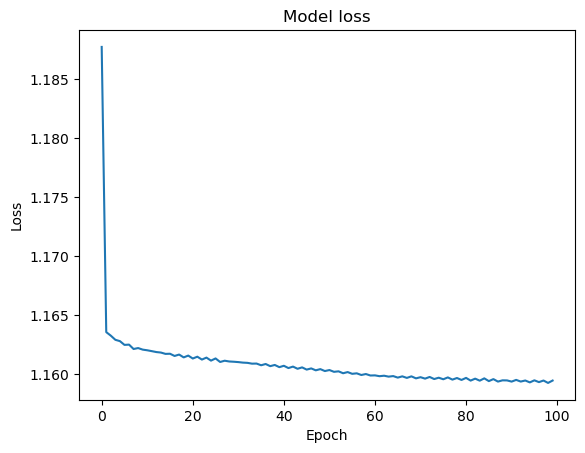

In [89]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel( 'Epoch')
plt.show()

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model(feature_set_size):
    model = Sequential()
    model.add(Dense(128, input_dim=feature_set_size, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mse'])
    return model

model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=128, verbose=1, validation_split=0.2)

y_pred_scaled = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred_scaled, model_name)
print(f"RMSE for {model_name}: {rmse_error}")


Epoch 1/200


C:\Users\Shaikh Basim\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3694 - mse: 0.3694 - val_loss: 0.3321 - val_mse: 0.3321
Epoch 2/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3556 - mse: 0.3556 - val_loss: 0.3319 - val_mse: 0.3319
Epoch 3/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3556 - mse: 0.3556 - val_loss: 0.3313 - val_mse: 0.3313
Epoch 4/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3551 - mse: 0.3551 - val_loss: 0.3311 - val_mse: 0.3311
Epoch 5/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3532 - mse: 0.3532 - val_loss: 0.3309 - val_mse: 0.3309
Epoch 6/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3545 - mse: 0.3545 - val_loss: 0.3309 - val_mse: 0.3309
Epoch 7/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3545 - mse: 0.3545 - val_loss: 0.3314 - val_mse: 0.3314
Epoch 8/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3552 - mse: 0.3552 - val_loss: 0.3317 - val_mse: 0.3317
Epoch 9/200
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

# Improved the models but still not feasible so we go back to where we calculate vif and only work with vif scores less than 5

In [91]:
pred_df = pd.DataFrame.from_dict(pred_dict)
pred_df = pred_df[pred_df["RMSE"].apply(lambda x: isinstance(x, (float, int)))]

pred_dict = pred_df.to_dict(orient="list")
pred_df.sort_values(by='RMSE')


,regression_model,feature_set,scaler_name,RMSE
24,Ridge,selected_features_20,StandardScaler,1065.079131
29,MLP,selected_features_20,StandardScaler,1082.862109
25,DecisionTree,selected_features_20,StandardScaler,1090.91312
26,RandomForest,selected_features_20,StandardScaler,1164.588252
28,LGBM,selected_features_20,StandardScaler,1856.859362
4,LGBM,full_dataset,StandardScaler,2072.891512
10,LGBM,full_dataset,MinMaxScaler,2073.776484
16,LGBM,selected_features_20,StandardScaler,2073.79568
5,MLP,full_dataset,StandardScaler,2075.396729
17,MLP,selected_features_20,StandardScaler,2076.923584


In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif2(features) :
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(values_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [99]:
features = values_df.drop(columns=["Totaltime"]).columns.to_list()
vif_data = compute_vif2(features)
vif_data

C:\Users\Shaikh Basim\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\Shaikh Basim\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\Shaikh Basim\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,estimated_order_place_duration,10.665974
1,prep_duration_prediction,inf
2,estimated_store_to_consumer_driving_duration,inf
3,sum,inf


In [101]:
features = values_df.drop(columns=["Totaltime", "sum"]).columns.to_list()
vif_data = compute_vif2(features)
print(vif_data)


                                        feature        VIF
0  estimated_store_to_consumer_driving_duration   6.618287
1                estimated_order_place_duration  10.665974
2                      prep_duration_prediction  14.504793


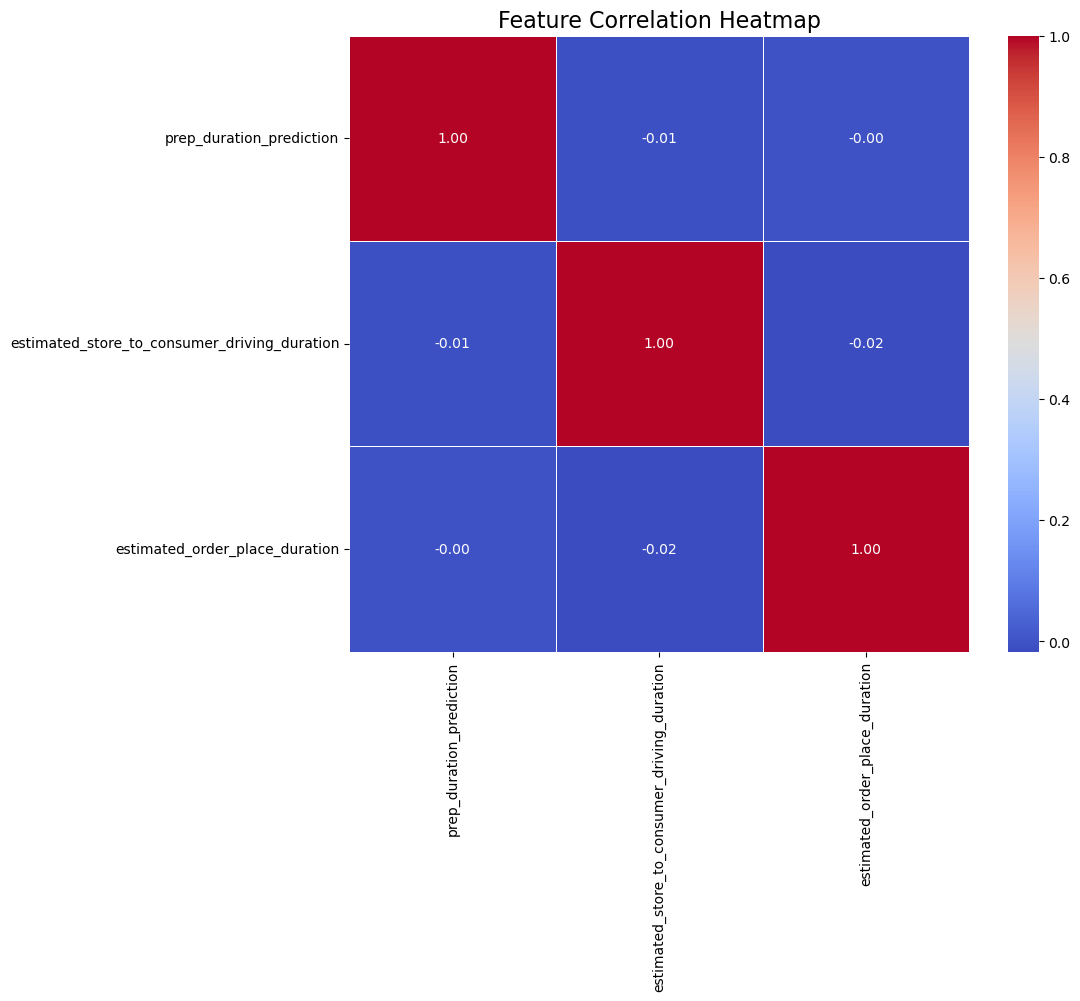

In [104]:
correlation_matrix = values_df.drop(columns=["Totaltime", "sum"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()


In [107]:
multicollinearity = True
while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data['VIF'] > 5]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data


I will remove percent_distinct_item_of_total
I will remove estimated_order_place_duration
I will remove estimated_store_to_consumer_driving_duration
I will remove busyRatio
I will remove avg_price_per_item


,feature,VIF
0,category_chocolate,1.000004
1,category_alcohol-plus-food,1.000019
2,category_belgian,1.000055
3,category_comfort-food,1.000321
4,category_gluten-free,1.000344
...,...,...
72,category_pizza,1.469321
73,price_range_of_items,2.247566
74,total_outstanding_orders,2.479540
75,total_items,2.950165


In [111]:
selected_features = vif_data[vif_data['VIF'] < 5]['feature'].values.tolist()

filtered_values_df = train_df[selected_features + ["Totaltime"]].copy()


if "prep_duration_prediction" in filtered_values_df.columns and "estimated_store_to_consumer_driving_duration" in filtered_values_df.columns:
    filtered_values_df['sum'] = (
        filtered_values_df['prep_duration_prediction'] +
        filtered_values_df['estimated_store_to_consumer_driving_duration']
    )

filtered_values_df.head()


,category_chocolate,category_alcohol-plus-food,category_belgian,category_comfort-food,category_gluten-free,category_russian,category_european,category_african,category_spanish,category_cheese,...,category_burger,category_japanese,category_mexican,category_american,category_pizza,price_range_of_items,total_outstanding_orders,total_items,prep_time,Totaltime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,682.0,21.0,4.0,2918.0,3779.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3334.0,4024.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1091.0,1781.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1200.0,2.0,6.0,2786.0,3075.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,500.0,9.0,3.0,1740.0,2390.0


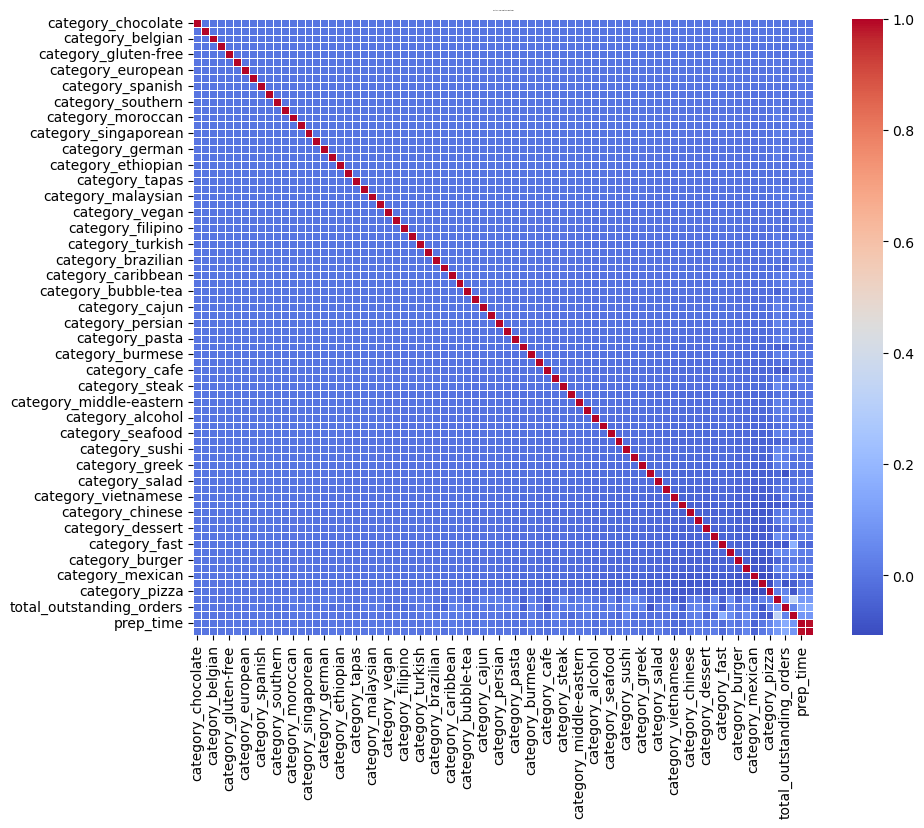

In [115]:
correlation_matrix = filtered_values_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap", fontsize=1)
plt.show()


# And the final metrics are provided down below and looks like on average the model is off by 3 mins

In [121]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = filtered_values_df.drop(columns=["Totaltime"]).values
y = filtered_values_df["Totaltime"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge(alpha=1.0) 
ridge_model.fit(X_train_scaled, y_train)

y_pred = ridge_model.predict(X_test_scaled)

# Metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ridge Regression Performance Metrics:")
print("RMSE:", rmse)  
print("MAE:", mae)
print("R^2 Score:", r2)

metrics = {
    "RMSE": rmse,
    "MAE": mae,
    "R^2": r2
}
metrics


Ridge Regression Performance Metrics:
RMSE: 217.37956
MAE: 177.55794
R^2 Score: 0.9892996285117984


{'RMSE': 217.37956, 'MAE': 177.55794, 'R^2': 0.9892996285117984}